<a href="https://colab.research.google.com/github/alhossainn/FixMatch-Unofficial-PyTorch-Implementation/blob/main/fixmatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

import platform
import psutil

import random
import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

import PIL
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import ImageEnhance, ImageOps, ImageFilter
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

from tabulate import tabulate

### Configuration

In [ ]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 12.67
GPU: Tesla T4


### Seed Value

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Dataset

In [ ]:
root_dir = "/content/drive/MyDrive/Colab Notebooks/dataset"

file_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: happy, Count: 250
Class: Angry, Count: 250
Class: Sad, Count: 250


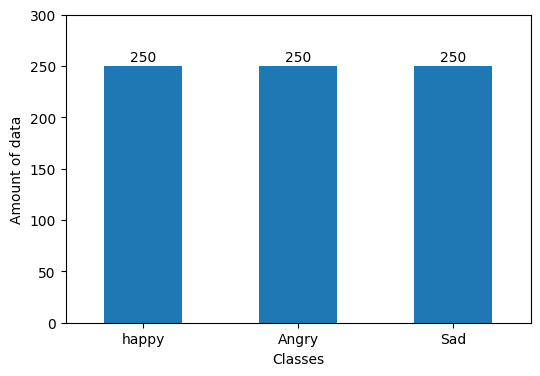

In [ ]:
class_counts_df = df['label'].value_counts()

for class_name, count in class_counts_df.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_df.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_df):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_df) * 1.2)
plt.show()

### Sample Image

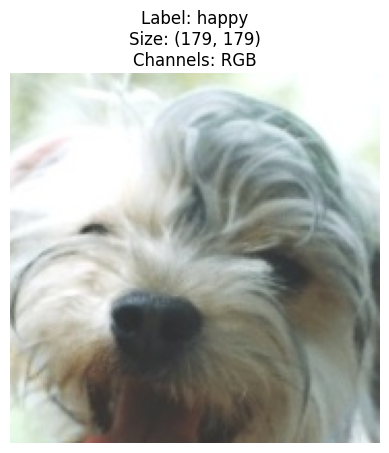

In [ ]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'
plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image)
plt.axis('off')
plt.show()

### Dataset Splits

In [ ]:
train_dataframe, test_dataframe = train_test_split(df, test_size=0.2, random_state=42)
test_dataframe, valid_dataframe = train_test_split(test_dataframe, test_size=0.5, random_state=42)
ulb_dataframe, lb_dataframe = train_test_split(train_dataframe, test_size=0.1, random_state=42)

In [ ]:
print("Unlabeled Data: ", len(ulb_dataframe))
print("Labeled Data: ", len(lb_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Unlabeled Data:  540
Labeled Data:  60
Validation Data:  75
Test Data:  75
-------------------------------------------
Total amounts of data in the dataset:  750


In [ ]:
class_counts_lb = lb_dataframe['label'].value_counts()
class_counts_ulb = ulb_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_dataframe['label'].value_counts()

lb_table_data = [[class_name, count] for class_name, count in class_counts_lb.items()]
ulb_table_data = [[class_name, count] for class_name, count in class_counts_ulb.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Labeled Dataset")
print(tabulate(lb_table_data, headers=["Class", "Count"]))
print("\nUnlabeled Dataset")
print(tabulate(ulb_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Labeled Dataset
Class      Count
-------  -------
happy         22
Angry         19
Sad           19

Unlabeled Dataset
Class      Count
-------  -------
happy        182
Angry        182
Sad          176

Validation Dataset
Class      Count
-------  -------
happy         26
Sad           26
Angry         23

Test Dataset
Class      Count
-------  -------
Sad           29
Angry         26
happy         20


### Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Variables

In [ ]:
total_class = 3
threshold_value = 0.95

### Batch Sizes

In [ ]:
mu = 4
lb_batch = 8
ulb_batch = mu*lb_batch
val_batch = 8
print("Batch Size of Labeled Data: ", lb_batch)
print("Batch Size of Unlabeled Data: ", lb_batch,"x",mu, " = ", ulb_batch)
print("Batch Size of Validation Data: ", val_batch)

Batch Size of Labeled Data:  8
Batch Size of Unlabeled Data:  8 x 4  =  32
Batch Size of Validation Data:  8


### Checkpoint

In [ ]:
save_path_checkpoints = "/content/drive/MyDrive/Colab Notebooks/checkpoint"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Augmentations

In [ ]:
class ImageDatasetWithAugmentation(Dataset):
    def __init__(self, dataframe, weak_transform, strong_transform, normalize, is_lb=False):
        self.dataframe = dataframe
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Angry': 0, 'happy': 1, 'Sad': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(self.weak_transform(image)), label
        else:
            weak_image = self.weak_transform(image)
            strong_image = self.strong_transform(image)
            return self.normalize(weak_image), self.normalize(strong_image)

In [ ]:
class ImageDatasetNoAugmentation(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Angry': 0, 'happy': 1, 'Sad': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [ ]:
def train_data_transfrom():

    def ShearX(img, v):  # [-0.3, 0.3]
        assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


    def ShearY(img, v):  # [-0.3, 0.3]
        assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


    def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v = -v
        v = v * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


    def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v = -v
        v = v * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


    def Rotate(img, v):  # [-30, 30]
        assert -30 <= v <= 30
        if random.random() > 0.5:
            v = -v
        return img.rotate(v)


    def AutoContrast(img, _):
        return PIL.ImageOps.autocontrast(img)


    def Invert(img, _):
        return PIL.ImageOps.invert(img)


    def Equalize(img, _):
        return PIL.ImageOps.equalize(img)


    def Solarize(img, v):  # [0, 256]
        assert 0 <= v <= 256
        inverted_v = 256 - v
        return PIL.ImageOps.solarize(img, inverted_v)


    def Posterize(img, v):  # [4, 8]
        v = int(v)
        v = max(1, v)
        return PIL.ImageOps.posterize(img, v)


    def Contrast(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        enhanced_v = 1.9 - v + 0.1
        return PIL.ImageEnhance.Contrast(img).enhance(enhanced_v)


    def Color(img, v):
        assert 0.1 <= v <= 1.9
        v = 1.9 - v
        return PIL.ImageEnhance.Color(img).enhance(v)


    def Brightness(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        v = 1.9 - v
        return PIL.ImageEnhance.Brightness(img).enhance(v)


    def Sharpness(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        return PIL.ImageEnhance.Sharpness(img).enhance(v)


    def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
        # assert 0 <= v <= 20
        if v < 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(w)
        y0 = np.random.uniform(h)

        x0 = int(max(0, x0 - v / 2.))
        y0 = int(max(0, y0 - v / 2.))
        x1 = min(w, x0 + v)
        y1 = min(h, y0 + v)

        xy = (x0, y0, x1, y1)
        color = (125, 123, 114)
        # color = (0, 0, 0)
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle(xy, color)
        return img


    def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
        assert 0.0 <= v <= 0.3
        if v <= 0.:
            return img

        v = v * img.size[0]
        return CutoutAbs(img, v)


    def Identity(img, v):
        return img


    def augment_list():
        aug_list = [
            (AutoContrast, 0, 1),
            (Equalize, 0, 1),
            (Invert, 0, 1),
            (Rotate, 0, 30),
            (Posterize, 0, 4),
            (Solarize, 0, 256),
            (Color, 0.1, 1.9),
            (Contrast, 0.1, 1.9),
            (Brightness, 0.1, 1.9),
            (Sharpness, 0.1, 1.9),
            (ShearX, 0.0, 0.3),
            (ShearY, 0.0, 0.3),
            (Cutout, 0, 0.3),
            (TranslateX, 0.0, 0.33),
            (TranslateY, 0.0, 0.33),
            (Identity, 0, 1)
        ]

        return aug_list


    class RandAugment:
        def __init__(self, n, m):
            self.n = n
            self.m = m      # [0, 30]
            self.augment_list = augment_list()

        def __call__(self, img):
            ops = random.choices(self.augment_list, k=self.n)
            for op, minval, maxval in ops:
                val = (float(self.m) / 30) * float(maxval - minval) + minval
                img = op(img, val)

            return img


    strong_transform = transforms.Compose([
        RandAugment(n=4, m=10)
    ])

    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    ])

    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    ulb_dataset = ImageDatasetWithAugmentation (
        ulb_dataframe,
        weak_transform,
        strong_transform,
        normalize,
        is_lb=False
    )

    lb_dataset = ImageDatasetWithAugmentation(
        lb_dataframe,
        weak_transform,
        strong_transform,
        normalize,
        is_lb=True
    )

    dataloader_ulb_dataset = DataLoader(ulb_dataset, batch_size = ulb_batch, shuffle=True, num_workers=2)
    dataloader_lb_dataset = DataLoader(lb_dataset, batch_size = lb_batch, shuffle=True, num_workers=2)

    return dataloader_ulb_dataset, dataloader_lb_dataset

dataloader_ulb_dataset, dataloader_lb_dataset = train_data_transfrom()

In [ ]:
def valid_data_transfrom():

    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    valid_dataset = ImageDatasetNoAugmentation(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDatasetNoAugmentation(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_valid_dataset, dataloader_test_dataset

dataloader_valid_dataset, dataloader_test_dataset = valid_data_transfrom()

### Neural Network

In [ ]:
learning_rate = 0.0001

model = models.resnet34(pretrained=True)

# fine tuning
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

summary(model, input_size=(lb_batch, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 3]                    --
├─Conv2d: 1-1                            [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [8, 64, 56, 56]           --
│

# FixMatch Training

##### FixMatch Implementation

In [ ]:
def train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold):
    model.train()

    losses = []
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(dataloader_lb_dataset)

    ulb_iter = iter(dataloader_ulb_dataset)

    for batch_lb in pbar:
        model.zero_grad()

        # labelled data
        x_lb, y = batch_lb
        x_lb, y = x_lb.to(device), y.to(device)

        # unlabelled data
        try:
            x_weak, x_strong = next(ulb_iter)
        except StopIteration:
            ulb_iter = iter(dataloader_ulb_dataset)
            x_weak, x_strong = next(ulb_iter)

        x_weak, x_strong = x_weak.to(device), x_strong.to(device)

        # concat all x
        all_x = torch.cat([x_lb, x_weak, x_strong], dim=0)

        # compute logits
        all_logits = model(all_x)

        # logits and loss for labelled data
        logits_lb = all_logits[:x_lb.size(0)]
        loss_lb = F.cross_entropy(logits_lb, y)

        # logits for unlabelled data
        logits_ulb = all_logits[x_lb.size(0):]
        logits_weak, logits_strong = torch.chunk(logits_ulb, 2, dim=0)

        # stop gradient for weak augmented
        logits_weak = logits_weak.detach()

        # compute class probabilities
        probs_weak = F.softmax(logits_weak, dim=1)

        # compute pseudo labels (torch.max outputs the maximum values and the argmax)
        max_prob, pseudo_label = torch.max(probs_weak, dim=1)

        # mask for confident predictions
        mask = (max_prob > threshold).float()

        # mask non-confident prediction
        pseudo_label = pseudo_label.masked_fill(mask == 0, 0)

        # unsupervised loss by ignoring non-confident prediction
        loss_ulb = F.cross_entropy(logits_strong, pseudo_label, ignore_index=-1)

        # total loss
        loss = loss_lb + loss_ulb

        # compute accuracy for labeled data
        _, predicted = torch.max(logits_lb, 1)
        correct_predictions += (predicted == y).sum().item()
        total_samples += y.size(0)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        losses.append(loss_item)

        pbar.set_description(f'train loss = {np.array(losses).mean():.3f}, accuracy = {correct_predictions / total_samples:.3f}')

        fig, axes = plt.subplots(1, 10, figsize=(6, 4))
        for i, ax in enumerate(axes.flat):
            ax.imshow(x_strong[i].cpu().permute(1, 2, 0))
            ax.axis('off')
            # ax.set_title(f'Label: {y[i].item()}')
        plt.show()

    return np.array(losses).mean(), correct_predictions / total_samples

##### Validation

In [ ]:
def validate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    val_losses = []

    with torch.no_grad():
        for batch in dataloader:
            x_val, y_val = batch
            x_val, y_val = x_val.to(device), y_val.to(device)

            logits_val = model(x_val)
            loss_val = F.cross_entropy(logits_val, y_val)

            _, predicted_val = torch.max(logits_val, 1)
            correct_predictions += (predicted_val == y_val).sum().item()
            total_samples += y_val.size(0)

            val_losses.append(loss_val.item())

    accuracy = correct_predictions / total_samples
    val_loss = np.array(val_losses).mean()

    return accuracy, val_loss

##### Training

  0%|          | 0/8 [00:00<?, ?it/s]

1


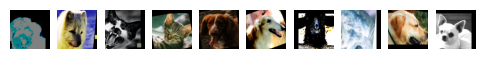

2


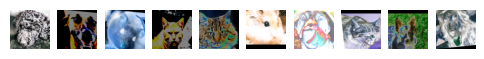

3


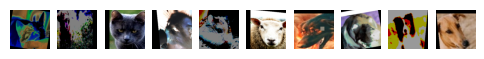

4


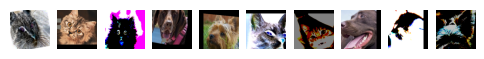

5


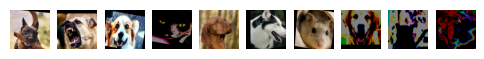

6


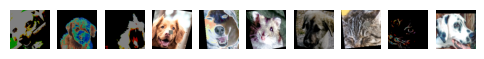

7


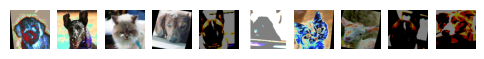

8


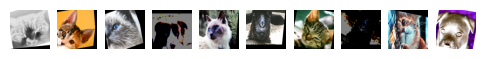

Epoch 1/5 - Train Loss: 2.439, Train Accuracy: 0.333 - Validation Loss: 1.212, Validation Accuracy: 0.373
Best model saved at epoch 1 with validation accuracy: 0.373


  0%|          | 0/8 [00:00<?, ?it/s]

9


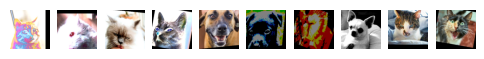

10


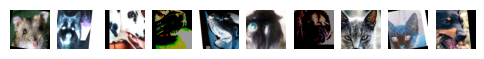

11


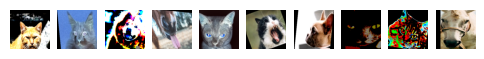

12


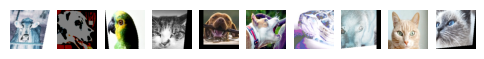

13


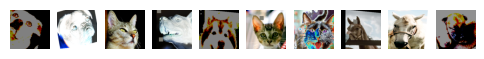

14


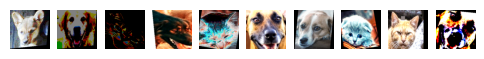

15


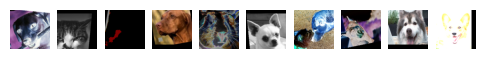

16


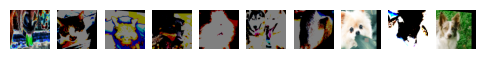

Epoch 2/5 - Train Loss: 1.649, Train Accuracy: 0.367 - Validation Loss: 1.578, Validation Accuracy: 0.307


  0%|          | 0/8 [00:00<?, ?it/s]

17


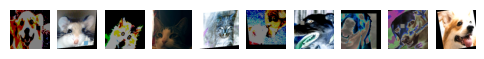

18


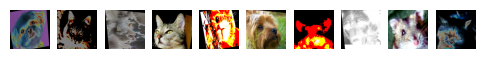

19


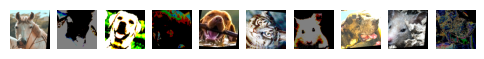

20


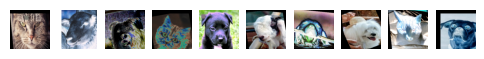

21


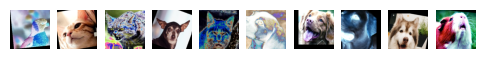

22


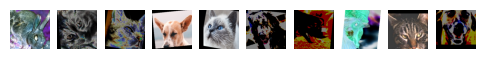

23


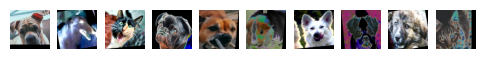

24


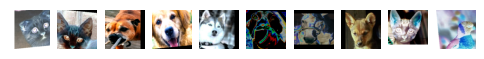

Epoch 3/5 - Train Loss: 1.581, Train Accuracy: 0.317 - Validation Loss: 1.449, Validation Accuracy: 0.320


  0%|          | 0/8 [00:00<?, ?it/s]

25


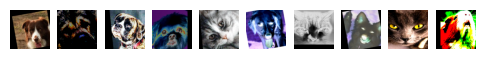

26


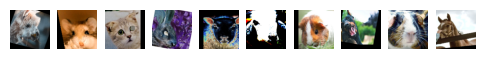

27


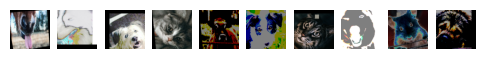

28


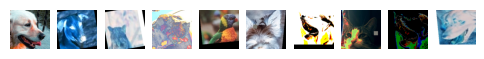

29


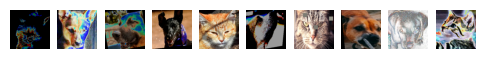

30


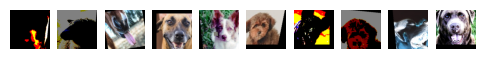

31


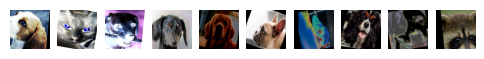

32


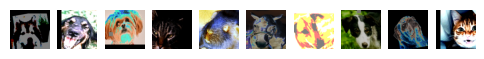

Epoch 4/5 - Train Loss: 1.395, Train Accuracy: 0.333 - Validation Loss: 1.221, Validation Accuracy: 0.387
Best model saved at epoch 4 with validation accuracy: 0.387


  0%|          | 0/8 [00:00<?, ?it/s]

33


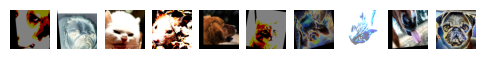

34


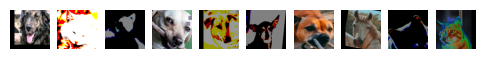

35


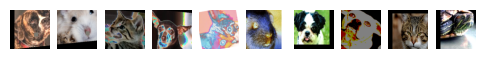

36


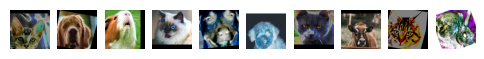

37


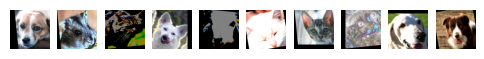

38


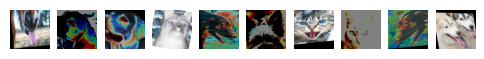

39


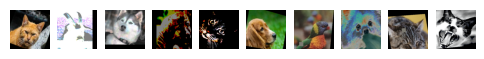

40


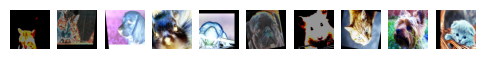

Epoch 5/5 - Train Loss: 1.228, Train Accuracy: 0.483 - Validation Loss: 1.157, Validation Accuracy: 0.427
Best model saved at epoch 5 with validation accuracy: 0.427
Training complete.........
Training Time: 374.7687916755676 seconds
Training Time: 6.246146527926127 minitues


In [ ]:
import time
start_time = time.time()

num_epochs = 5
early_stopping_rounds = 5
total_iterations = 0

num_epochs_without_improvement = 0
num_epochs_loss_greater = 0

losses = []
accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
prev_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold=threshold_value)
    val_accuracy, val_loss = validate(model, dataloader_valid_dataset, device)

    losses.append(train_loss)
    accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f} - '
          f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        filepath = f"{save_path_checkpoints}/model.pt"
        checkpoint = {
            "epoch": epoch + 1,
            "model_weight": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }
        torch.save(checkpoint, filepath)
        print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_accuracy:.3f}")
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1

    if val_loss > train_loss:
        num_epochs_loss_greater += 1
    else:
        num_epochs_loss_greater = 0

    if num_epochs_without_improvement >= early_stopping_rounds or num_epochs_loss_greater >= early_stopping_rounds:
        print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stopping_rounds} consecutive epochs. Training stopped.")
        break

print("Training complete.........")

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")
print("Training Time:", training_time/60, "minitues")

In [ ]:
print(losses)
print()
print(accuracies)
print()
print(val_losses)
print()
print(val_accuracies)

[2.438968777656555, 1.6491172537207603, 1.5807950347661972, 1.3950941860675812, 1.2282922714948654]

[0.3333333333333333, 0.36666666666666664, 0.31666666666666665, 0.3333333333333333, 0.48333333333333334]

[1.2115533232688904, 1.5781552076339722, 1.4490904688835144, 1.2207773447036743, 1.1566675901412964]

[0.37333333333333335, 0.30666666666666664, 0.32, 0.38666666666666666, 0.4266666666666667]


##### Plots

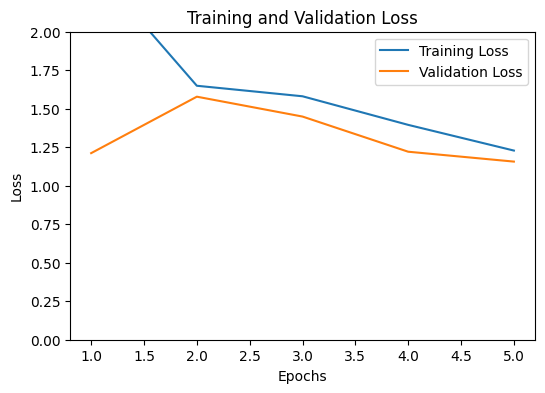

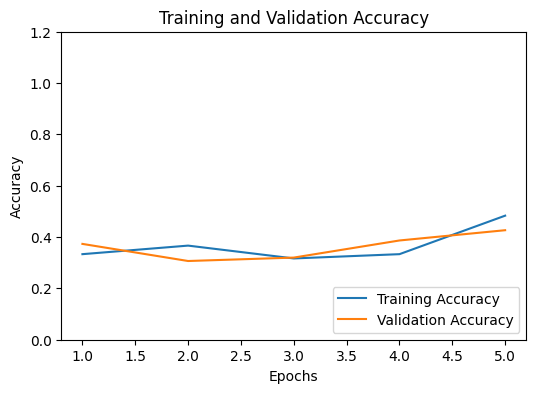

In [ ]:
epochs = range(1, len(losses)+1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.2)
plt.show()

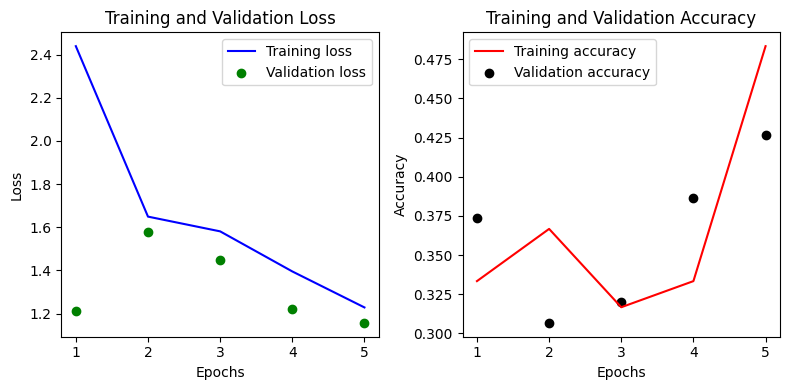

In [ ]:
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(8, 4))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'blue', label='Training loss')
plt.scatter(epochs, val_losses, color='green', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'red', label='Training accuracy')
plt.scatter(epochs, val_accuracies, color='black', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### FixMatch Model Evaluation

In [ ]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_accuracy, best_val_loss = validate(model, dataloader_valid_dataset, device)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

test_accuracy, test_loss = validate(model, dataloader_test_dataset, device)
print(f"Test Accuracy: {test_accuracy:.3f}")

Best model (from epoch 5) - Validation Loss: 1.157, Validation Accuracy: 0.427
Test Accuracy: 0.373


In [ ]:
def get_predictions_labels(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(y.cpu().numpy())

    return all_predictions, all_labels

test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

class_names = [str(i) for i in range(total_class)]
val_classification_report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:")
print(val_classification_report)

def class_accuracy(predictions, labels, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for pred, label in zip(predictions, labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

class_acc = class_accuracy(test_predictions, test_labels, total_class)

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.3f}")

print()
print("Angry: 0, happy: 1, Sad: 2")